# Machine Learning Models

## 1. Load Dataset

Cleaned Dataset (from [Statistical Analysis](../StatisticalAnalysis/StatisticalAnalysis.py)) is loaded and splitted into training and testing dataset with a 0.25 `test_size` using the `train_test_split` function of [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with stratify by `Quality of Sleep`. Due to insufficient training instances and class imbalance is necessary to perform a stratified split that benefits the training dataset (meaning, a smaller test dataset).

In [52]:
# Importing libraries and functionalities
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split


# Importing functions and utils
import SourceMachineLearning as src

In [53]:
# Loading dataset

SleepDataset = pd.read_csv(
    src.PATH+'CleanSleepDataset.csv',
    index_col = 0,
)

In [54]:
# Splitting columns into features (numerical, binary, categorical) and target

Target = 'Quality of Sleep'
Features = [feature for feature in SleepDataset.columns if feature != Target]

NumericalFeatures , BinaryFeatures, CategoricalFeatures = src.SplittingFeatures(SleepDataset,Features)

In [55]:
# Splitting dataset into train and test

SleepDataset_Train , SleepDataset_Test = train_test_split(
    SleepDataset,
    test_size = 0.25,
    stratify = SleepDataset[Target],
    random_state = src.RANDOM_STATE,
)

## 2. Preprocessing Pipeline

For the dataset preprocessing, each of the categorical features are encoded and the numerical features are standardized. The encoding will allow the model to learn from categorical features, while standardization reduces noise by different scales. No feature engineering was applied during preprocessing neither feature selection (although some features have a high linear correlation with each other).

In [56]:
# Importing functionalities

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler , OrdinalEncoder , OneHotEncoder 

In [57]:
# Pipelines for preprocessing by type of feature

NumericalPreprocessing = Pipeline(
    [
        ('Standardization',StandardScaler()),
    ]
)

BinaryPreprocessing = Pipeline(
    [
        ('Encoder',OrdinalEncoder()),
    ]
)

CategoricalPreprocessing = Pipeline(
    [
        ('Encoder',OneHotEncoder()),
    ]
)

# Pipeline for preprocessing

PreprocessingPipeline = ColumnTransformer(
    [
        ('Numerical Preprocessing',NumericalPreprocessing,NumericalFeatures),
        ('Binary Preprocessing',BinaryPreprocessing,BinaryFeatures),
        ('Categorical Preprocessing',CategoricalPreprocessing,CategoricalFeatures),
    ]
)

PreprocessingPipeline

,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## 3. Models

`Quality of Sleep` is a discrete feature (each value represents a class) which implies that the models should be classifiers to model properly the quality of sleep of a patient. The models that were chosen represent a reduced collection of techniques and ways of approaching the classification problem, where the priority was to have a greater diversification of them. Specifically, the following were chosen:
* Logistic Regression
* Random Forest
* SVM
* AdaBoost

With the definition of the models and hyperparameters to be optimized (the more suitable and flexible to optimize), the model fine-tunning is performed using [Optuna](https://optuna.org/) as framework to search for the best hyperparameters of each model. For determining the best hyperparameters, F1 score with weighted average is used because the dataset is imbalanced with respect to the target (`Quality of Sleep`) and this metric will reduce the generation of trivial models that excel at predicting the majority classes. Finally, the models with the best hyperparameters are saved (dumped).

### 3.1. Logistic Regression

In [58]:
# Defining Logistic Regression model

from sklearn.linear_model import LogisticRegression

LogisticRegressionPipeline = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Model',LogisticRegression(
            penalty='elasticnet',solver='saga',
            random_state=src.RANDOM_STATE,n_jobs=-1
        )),
    ]
)

LogisticRegressionParameters = {
    'Model__C':('float',[1e-10,2]),
    'Model__l1_ratio':('float',[0,1]),
}


LogisticRegressionPipeline

,steps,"[('Preprocessing', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 3.2. Random Forest

In [59]:
# Defining Random Forest model

from sklearn.ensemble import RandomForestClassifier

RandomForestPipeline = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Model',RandomForestClassifier(
            random_state=src.RANDOM_STATE,n_jobs=-1,
        )),
    ]
)

RandomForestParameters = {
    'Model__n_estimators': ('int',[1,50]),
    'Model__max_depth': ('int',[1,6]),
    'Model__criterion': ('categorical',['gini','entropy'])
}


RandomForestPipeline

,steps,"[('Preprocessing', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 3.3. Support Vector Machine (SVM)

In [60]:
# Defining Support Vector Machine model

from sklearn.svm import SVC

SVMPipeline = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Model',SVC(
            random_state=src.RANDOM_STATE,
        )),
    ]
)

SVMParameters = {
    'Model__C':('float',[1e-10,2]),
    'Model__kernel':('categorical',['poly','rbf','sigmoid']),
    'Model__degree':('int',[1,5]),
    'Model__gamma':('float',[1e-10,2]),
    'Model__coef0':('float',[0,2]),
}


SVMPipeline

,steps,"[('Preprocessing', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 3.4. Adaptive Boosting (AdaBoost)

In [61]:
# Defining Random Forest model

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

AdaBoostPipeline = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Model',AdaBoostClassifier(
            random_state=src.RANDOM_STATE,
        )),
    ]
)

base_estimators = [DecisionTreeClassifier(max_depth=depth,random_state=src.RANDOM_STATE) for depth in range(1,3)]
AdaBoostParameters = {
    'Model__estimator':('categorical',base_estimators),
    'Model__n_estimators':('int',[1,50]),
    'Model__learning_rate':('float',[1e-12,2]),
}


AdaBoostPipeline

,steps,"[('Preprocessing', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 3.5. Training and Fine-Tunning Models

In [62]:
# Defining containers for models and their params to optimize, 
# and variables for saving best models

ModelNames = [
    'Logistic Regression',
    'Random Forest',
    'SVM',
    'AdaBoost',
]

ModelsParams = [
    (LogisticRegressionPipeline,LogisticRegressionParameters),
    (RandomForestPipeline,RandomForestParameters),
    (SVMPipeline,SVMParameters),
    (AdaBoostPipeline,AdaBoostParameters)
]

In [67]:
# Importing auxiliars para ignore warnings

import warnings
from sklearn.exceptions import ConvergenceWarning

# Fine-tunning and training of models

from copy import deepcopy

BestModels = []
_NumTrials = 10
_Metric = src.F1_ML
with warnings.catch_warnings():
    warnings.simplefilter('ignore',category=ConvergenceWarning)
    warnings.simplefilter('ignore',category=UserWarning)

    TrainDataset_X = SleepDataset_Train[Features]
    TrainDataset_y = SleepDataset_Train[Target]
    TestDataset_X = SleepDataset_Test[Features]
    TestDataset_y = SleepDataset_Test[Target]

    for (_model , _params) , _model_name in zip(ModelsParams,ModelNames):
        # Defining optimizer
        _trainer = src.MachineLearningTrainer(
            _model,
            _params,
            _Metric,
        )

        # Fine-tuning of hyperparameters
        print(f' Start Fine-Tuning of {_model_name} '.center(50,'='))
        _best_params = _trainer(
            TrainDataset_X,
            TrainDataset_y,
            TestDataset_X,
            TestDataset_y,
            NumTrials = _NumTrials,
            NumJobs = 1,
        )

        # Training model with the best parameters
        _best_model = deepcopy(_model)
        _best_model.set_params(**_best_params)
        _best_model.fit(TrainDataset_X,TrainDataset_y)
        BestModels.append(deepcopy(_best_model))

    print('\n',' Start Models Evaluation '.center(50,'='))
    for _best_model , _model_name in zip(BestModels,ModelNames):
        _score = _Metric(_best_model,TestDataset_X,TestDataset_y)
        print(f'Best {_model_name} Model obtains :: {_score} Score')

[I 2025-11-12 07:16:18,199] A new study created in memory with name: OptimizeModel


==== Start Fine-Tuning of Logistic Regression ====


[I 2025-11-12 07:16:18,447] Trial 0 finished with value: 0.9347082994832335 and parameters: {'Model__C': 1.4512349639483524, 'Model__l1_ratio': 0.6542642016175796}. Best is trial 0 with value: 0.9347082994832335.
[I 2025-11-12 07:16:18,593] Trial 1 finished with value: 0.9347082994832335 and parameters: {'Model__C': 1.754202506722847, 'Model__l1_ratio': 0.5293477250589322}. Best is trial 0 with value: 0.9347082994832335.
[I 2025-11-12 07:16:18,793] Trial 2 finished with value: 0.9346120252943435 and parameters: {'Model__C': 0.4796971495899362, 'Model__l1_ratio': 0.12869511452427285}. Best is trial 0 with value: 0.9347082994832335.
[I 2025-11-12 07:16:18,935] Trial 3 finished with value: 0.9246377834448449 and parameters: {'Model__C': 0.5773230876144587, 'Model__l1_ratio': 0.6448491254204678}. Best is trial 0 with value: 0.9347082994832335.
[I 2025-11-12 07:16:19,076] Trial 4 finished with value: 0.9156102856984651 and parameters: {'Model__C': 0.3407429455744103, 'Model__l1_ratio': 0.50

======= Start Fine-Tuning of Random Forest =======


[I 2025-11-12 07:16:20,336] Trial 0 finished with value: 0.9218960521872055 and parameters: {'Model__n_estimators': 38, 'Model__max_depth': 3, 'Model__criterion': 'entropy'}. Best is trial 0 with value: 0.9218960521872055.
[I 2025-11-12 07:16:20,625] Trial 1 finished with value: 0.9456210649939653 and parameters: {'Model__n_estimators': 47, 'Model__max_depth': 4, 'Model__criterion': 'gini'}. Best is trial 1 with value: 0.9456210649939653.
[I 2025-11-12 07:16:20,911] Trial 2 finished with value: 0.9559161854857939 and parameters: {'Model__n_estimators': 42, 'Model__max_depth': 4, 'Model__criterion': 'gini'}. Best is trial 2 with value: 0.9559161854857939.
[I 2025-11-12 07:16:21,197] Trial 3 finished with value: 0.9218960521872055 and parameters: {'Model__n_estimators': 41, 'Model__max_depth': 3, 'Model__criterion': 'entropy'}. Best is trial 2 with value: 0.9559161854857939.
[I 2025-11-12 07:16:21,484] Trial 4 finished with value: 0.7970017466888555 and parameters: {'Model__n_estimators'

============ Start Fine-Tuning of SVM ============


[I 2025-11-12 07:16:23,078] Trial 3 finished with value: 0.23599479402444545 and parameters: {'Model__C': 0.06252625998421829, 'Model__kernel': 'sigmoid', 'Model__degree': 1, 'Model__gamma': 1.8101140514171805, 'Model__coef0': 1.0515701003134987}. Best is trial 0 with value: 0.9787554956516157.
[I 2025-11-12 07:16:23,132] Trial 4 finished with value: 0.35268310669764286 and parameters: {'Model__C': 0.12829765889075403, 'Model__kernel': 'sigmoid', 'Model__degree': 3, 'Model__gamma': 0.6789337371311105, 'Model__coef0': 0.013155425816457011}. Best is trial 0 with value: 0.9787554956516157.
[I 2025-11-12 07:16:23,188] Trial 5 finished with value: 0.9665745975572915 and parameters: {'Model__C': 1.8583822155517462, 'Model__kernel': 'rbf', 'Model__degree': 5, 'Model__gamma': 1.287887347397269, 'Model__coef0': 0.06571569431082414}. Best is trial 0 with value: 0.9787554956516157.
[I 2025-11-12 07:16:23,234] Trial 6 finished with value: 0.9787554956516157 and parameters: {'Model__C': 1.408668368

========= Start Fine-Tuning of AdaBoost ==========


[I 2025-11-12 07:16:23,674] Trial 1 finished with value: 0.6626220170069592 and parameters: {'Model__estimator': DecisionTreeClassifier(max_depth=1, random_state=8013), 'Model__n_estimators': 8, 'Model__learning_rate': 0.14156334410197655}. Best is trial 0 with value: 0.6626220170069592.
[I 2025-11-12 07:16:23,819] Trial 2 finished with value: 0.2723404255319149 and parameters: {'Model__estimator': DecisionTreeClassifier(max_depth=1, random_state=8013), 'Model__n_estimators': 26, 'Model__learning_rate': 1.1697843764002887}. Best is trial 0 with value: 0.6626220170069592.
[I 2025-11-12 07:16:23,871] Trial 3 finished with value: 0.7026075385154371 and parameters: {'Model__estimator': DecisionTreeClassifier(max_depth=2, random_state=8013), 'Model__n_estimators': 2, 'Model__learning_rate': 0.26622452328252466}. Best is trial 3 with value: 0.7026075385154371.
[I 2025-11-12 07:16:24,072] Trial 4 finished with value: 0.2723404255319149 and parameters: {'Model__estimator': DecisionTreeClassifi


 ============ Start Models Evaluation =============
Best Logistic Regression Model obtains :: 0.9347082994832335 Score
Best Random Forest Model obtains :: 0.9910304547350856 Score
Best SVM Model obtains :: 0.9787554956516157 Score
Best AdaBoost Model obtains :: 0.9903212348769296 Score


In [ ]:
# Saving best models

for _best_model , _model_name in zip(BestModels,ModelNames):
    print('\n',f' Start Save {_model_name} Model '.center(50,'='))
    # src.SaveModel(_best_model,'./SaveModels/',_model_name)


 ====== Start Save Logistic Regression Model ======

 ========= Start Save Random Forest Model =========

 ============== Start Save SVM Model ==============

 =========== Start Save AdaBoost Model ============


## 4. Result Analysis and Model Comparison

In [69]:
# Saving best models

BestModels = []
for _model_name in ModelNames:
    print('\n',f' Start Load {_model_name} Model '.center(50,'='))
    _model = src.LoadModel('./SaveModels/',_model_name)
    BestModels.append(_model)


 ====== Start Load Logistic Regression Model ======

 ========= Start Load Random Forest Model =========

 ============== Start Load SVM Model ==============

 =========== Start Load AdaBoost Model ============


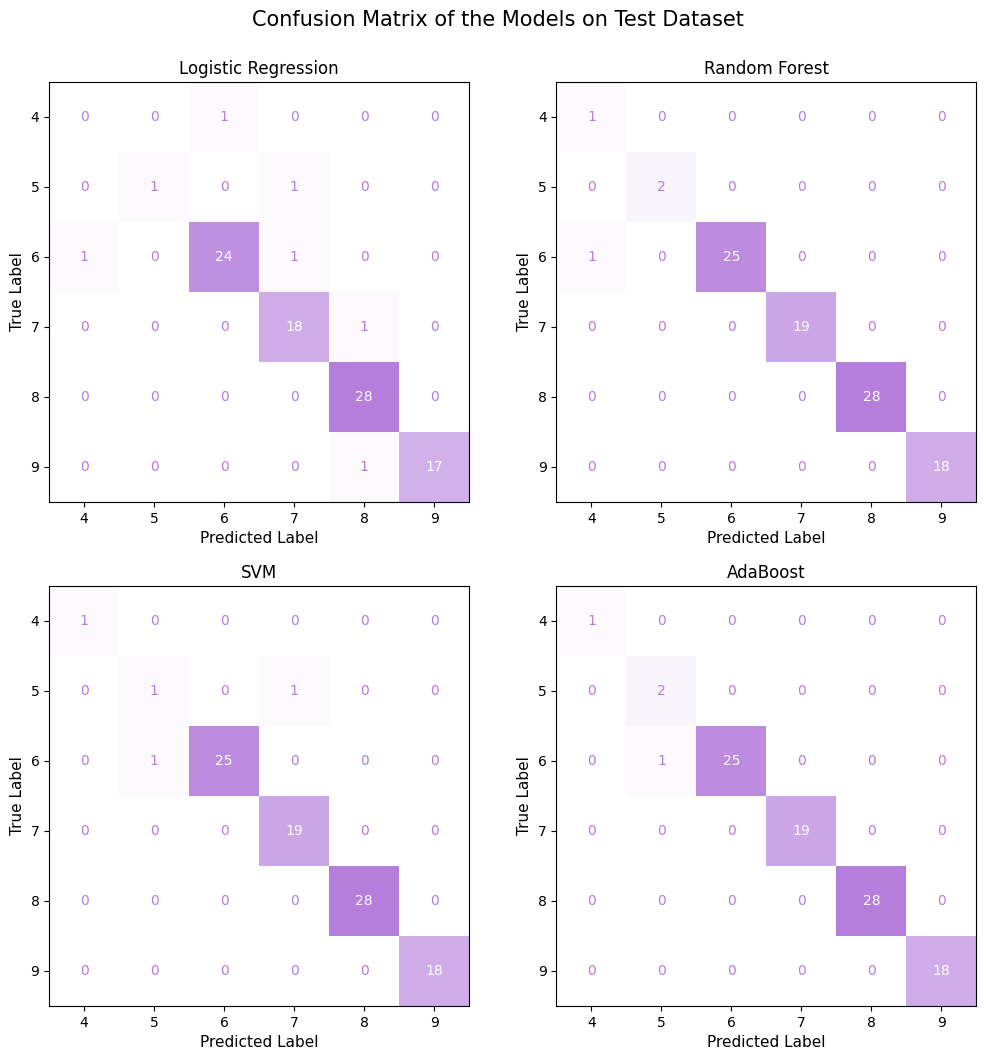

In [ ]:
# Plotting of confusion matrix by model

from sklearn.metrics import ConfusionMatrixDisplay

fig , axes = plt.subplots(2,2,figsize=(12,12))

for _best_model , _model_name , _ax in zip(BestModels,ModelNames,axes.ravel()):
    ConfusionMatrixDisplay.from_estimator(
        _best_model,
        TestDataset_X,
        TestDataset_y,
        cmap = ColorMapBinary,
        colorbar = False, 
        ax = _ax,
    )
    _ax.set_title(_model_name)
    _ax.set_xlabel('Predicted Label',size=11)
    _ax.set_ylabel('True Label',size=11)

fig.suptitle('Confusion Matrix of the Models on Test Dataset',y=0.94,size=15);

In [74]:
# Evaluating models

from sklearn.metrics import accuracy_score , precision_recall_fscore_support

EvaluationScoreResults = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'],dtype=float)
EvaluationScoreResults.rename_axis(index='Model',inplace=True)

for _best_model , _model_name in zip(BestModels,ModelNames):
    _pred_y = _best_model.predict(TestDataset_X)
    accuracy = accuracy_score(TestDataset_y,_pred_y)
    *metrics , _ = precision_recall_fscore_support(TestDataset_y,_pred_y,average='weighted')
    EvaluationScoreResults.loc[_model_name] = [accuracy,*metrics]

EvaluationScoreResults

,Accuracy,Precision,Recall,F1
Model,,,,
Logistic Regression,0.936170,0.938227,0.936170,0.934708
Random Forest,0.989362,0.994681,0.989362,0.991030
SVM,0.978723,0.979255,0.978723,0.978755
AdaBoost,0.989362,0.992908,0.989362,0.990321


In [77]:
from matplotlib.figure import Figure

def PlotResults(
        Results: pd.DataFrame,
        TypeDataset: str,    
    ) -> Figure:
    """
    Function for plot the results of 
    model evaluations.

    Parameters
    ----------
    Results: pd.DataFrame
        `pd.DataFrame` with the scores of each model
    TypeDataset: str
        Type of dataset used for getting the results

    Return
    ------
    Plot: Figure
        Plot with the results
    """

    Fig , Axes = plt.subplots(
        figsize=(9,7),
        subplot_kw={'frame_on':False,'ylim':(0.9,1)},
    )

    Results.plot(
        kind='bar',
        ax=Axes,
        legend=False,
        color=sns.color_palette('husl'),
    )
    Axes.grid(True,axis='y',color='gray',lw=1,ls=':')

    Axes.set_yticks(np.linspace(0.9,1,11))
    TicksLabels = Axes.get_xticklabels()
    Axes.set_xticks(range(len(TicksLabels)),TicksLabels,rotation=30)

    Axes.tick_params(axis='both',labelsize=15,width=0)
    Axes.set_xlabel(Axes.get_xlabel(),size=17)
    Axes.set_ylabel('Score',size=17)
    Axes.set_title(f'Results on\n{TypeDataset} Dataset',size=24)

    Axes.legend(fontsize=14)

    return Fig

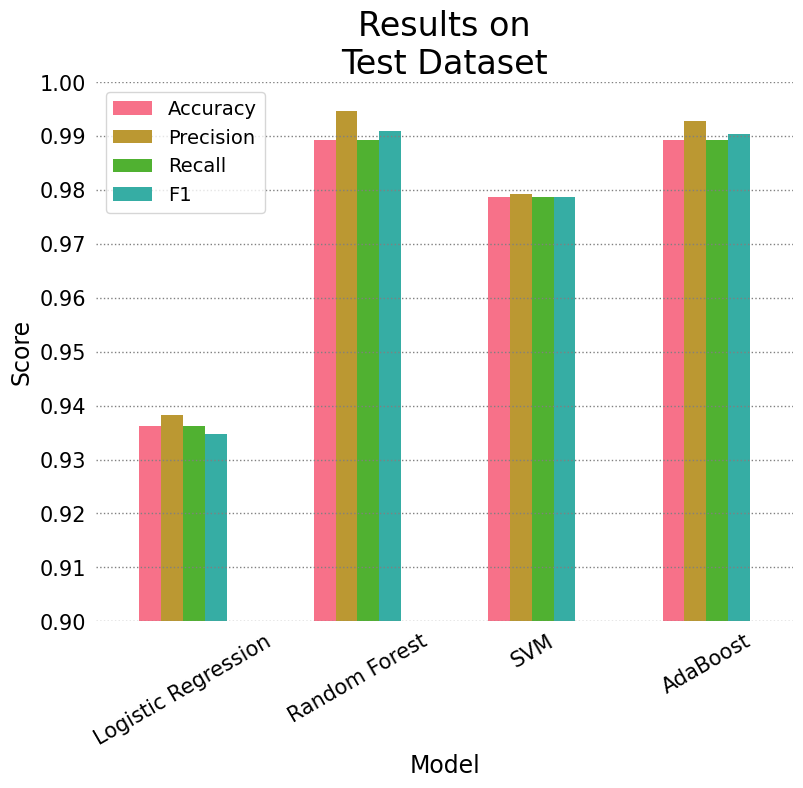

In [79]:
# Plotting models scores

PlotResults(EvaluationScoreResults,'Test');